# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import namedtuple
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
EPSILON = 1e-8 # small constant to avoid underflow or divide per 0
%matplotlib inline

# I - Data loading and preprocessing

## Load the data

#### This time, the data will correspond to greyscale images. <br> Two different datasets can be used here:
- The MNIST dataset, small 8*8 images, corresponding to handwritten digits &rightarrow; 10 classes
- The Fashion MNIST dataset, medium 28*28 images, corresponding to clothes pictures &rightarrow; 10 classes

#### Starting with the simple MNIST is recommended

In [2]:
dataset = "MNIST"
# dataset = "FASHION_MNIST"

In [3]:
def load_data(dataset='MNIST'):
    if dataset == 'MNIST':
        digits = load_digits()
        X, Y = np.asarray(digits['data'], dtype='float32'), np.asarray(digits['target'], dtype='int32')
        return X, Y
    elif dataset == 'FASHION_MNIST':
        import tensorflow as tf
        fashion_mnist = tf.keras.datasets.fashion_mnist
        (X, Y), (_, _) = fashion_mnist.load_data()
        X = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))
        X, Y = np.asarray(X, dtype='float32'), np.asarray(Y, dtype='int32')
        return X, Y
X, Y = load_data(dataset=dataset)

In [4]:
n_classes = len(np.unique(Y))

In [5]:
print('Number of samples: {:d}'.format(X.shape[0]))
print('Input dimension: {:d}'.format(X.shape[1]))  # images 8x8 or 28*28 actually
print('Number of classes: {:d}'.format(n_classes))

Number of samples: 1797
Input dimension: 64
Number of classes: 10


In [6]:
print("Range max-min of greyscale pixel values: ({0:.1f}, {1:.1f})".format(np.max(X), np.min(X)))
print("First image sample:\n{0}".format(X[0]))
print("First image label: {0}".format(Y[0]))
print("Input design matrix shape: {0}".format(X.shape))

Range max-min of greyscale pixel values: (16.0, 0.0)
First image sample:
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
First image label: 0
Input design matrix shape: (1797, 64)


### What does the data look like?
Each image in the dataset consists of a 8 x 8 (or 28 x 28) matrix, of greyscale pixels. For the MNIST dataset, the values are between 0 and 16 where 0 represents white, 16 represents black and there are many shades of grey in-between. For the Fashion MNIST dataset, the values are between 0 and 255.<br>Each image is assigned a corresponding numerical label, so the image in ```X[i]``` has its corresponding label stored in ```Y[i]```.

The next cells below demonstrate how to visualise the input data. Make sure you understand what's happening, particularly how the indices correspond to individual items in the dataset. 

## Visualize the data

In [7]:
def visualize_data_sample(X, Y, nrows=2, ncols=2):
    fig, ax = plt.subplots(nrows, ncols)
    for row in ax:
        for col in row:
            index = random.randint(0, X.shape[0])
            dim = np.sqrt(X.shape[1]).astype(int)
            col.imshow(X[index].reshape((dim, dim)), cmap=plt.cm.gray_r)
            col.set_title("image label: %d" % Y[index])
    plt.tight_layout()
    plt.show()

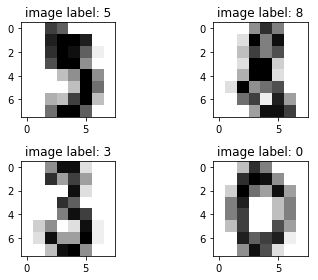

In [8]:
visualize_data_sample(X, Y)

# II - Multiclass classification MLP with Numpy

## II a) - Problem definition

<img src="../images/mlp_mnist.svg">

The task here will be to implement "from scratch" a Multilayer Perceptron for classification.

We will define the formal categorical cross entropy loss as follows:
$$
l(\mathbf{\Theta}, \mathbf{X}, \mathbf{Y}) = - \frac{1}{n} \sum_{i=1}^n \log \mathbf{f}(\mathbf{x}_i ; \mathbf{\Theta})^\top y_i
$$
<center>with $y_i$ being the one-hot encoded true label for the sample $i$, and $\Theta = (\mathbf{W}^h; \mathbf{b}^h; \mathbf{W}^o; \mathbf{b}^o)$</center>
<center>In addition, $\mathbf{f}(\mathbf{x}) = softmax(\mathbf{z^o}(\mathbf{x})) = softmax(\mathbf{W}^o\mathbf{h}(\mathbf{x}) + \mathbf{b}^o)$</center>
<center>and $\mathbf{h}(\mathbf{x}) = g(\mathbf{z^h}(\mathbf{x})) = g(\mathbf{W}^h\mathbf{x} + \mathbf{b}^h)$, $g$ being the activation function and could be implemented with $sigmoid$ or $relu$</center>

## Objectives:
- Write the categorical cross entropy loss function
- Write the activation functions with their associated gradient
- Write the softmax function that is going to be used to output the predicted probabilities
- Implement the forward pass through the neural network
- Implement the backpropagation according to the used loss: progagate the gradients using the chain rule and return $(\mathbf{\nabla_{W^h}}l ; \mathbf{\nabla_{b^h}}l ; \mathbf{\nabla_{W^o}}l ; \mathbf{\nabla_{b^o}}l)$
- Implement dropout regularization in the forward pass: be careful to consider both training and prediction cases
- Implement the SGD optimization algorithm, and improve it with simple momentum

#### Simple graph function to let you have a global overview:

<img src="../images/function_graph.png" style="width: 750px;"/>

### Hints

1) You may find numpy outer products useful: <br>
https://docs.scipy.org/doc/numpy/reference/generated/numpy.outer.html <br>
We have: $outer(u, v) = u \cdot v^T$, with $u, v$ two vectors

Example:

In [9]:
u, v = np.random.normal(size=(5,)), np.random.normal(size=(10,))
assert np.array_equal(
    np.outer(u, v),
    np.dot(np.reshape(u, (u.size, 1)), np.reshape(v, (1, v.size)))
)
assert np.outer(u, v).shape == (5, 10)

1) You also may find numpy matmul function useful: <br>
https://docs.scipy.org/doc/numpy/reference/generated/numpy.matmul.html <br>
It can be used to perform matrix products along one fixed dimension (i.e. the batch size)

Example:

In [10]:
A, B = np.random.randint(0, 100, size=(64, 5, 10)), np.random.randint(0, 100, size=(64, 10, 5))

In [11]:
assert np.array_equal(
    np.stack([np.dot(A_i, B_i) for A_i, B_i in zip(A, B)]),
    np.matmul(A, B)
)

In [45]:
Grads = namedtuple('Grads', ['W_h', 'b_h', 'W_o', 'b_o'])
test = Grads(1,2,3,4)
print(test.W_h)

velocities = {'W_h': 1., 'b_h': 1., 'W_o': 0., 'b_o': 0.}
velocities[:,] = 0.9*velocities[:,]
print(velocities['W_h'])

1


TypeError: unhashable type: 'slice'

## II b) - Implementation

In [ ]:
class MultiLayerPerceptron():
    """MLP with one hidden layer having a hidden activation,
    and one output layer having a softmax activation"""
    def __init__(self, X, Y, hidden_size, activation='relu',
                 initialization='uniform', dropout=False, dropout_rate=1):
        # input, hidden, and output dimensions on the MLP based on X, Y
        self.input_size, self.output_size = X.shape[1], len(np.unique(Y))
        self.hidden_size = hidden_size
        # initialization strategies: avoid a full-0 initialization of the weight matricest
        if initialization == 'uniform':
            self.W_h = np.random.uniform(size=(self.hidden_size, self.input_size), high=0.01, low=-0.01)
            self.W_o = np.random.uniform(size=(self.output_size, self.hidden_size), high=0.01, low=-0.01)
        elif initialization == 'normal':
            self.W_h = np.random.normal(size=(self.hidden_size, self.input_size), loc=0, scale=0.01)
            self.W_o = np.random.normal(size=(self.output_size, self.hidden_size), loc=0, scale=0.01)
        # the bias could be initializated to 0 or a random low constant
        self.b_h = np.zeros(self.hidden_size)
        self.b_o = np.zeros(self.output_size)
        # our namedtuple structure of gradients
        self.Grads = namedtuple('Grads', ['W_h', 'b_h', 'W_o', 'b_o'])
        # and the velocities associated which are going to be useful for the momentum
        self.velocities = {'W_h': 0., 'b_h': 0., 'W_o': 0., 'b_o': 0.}
        # the hidden activation function used
        self.activation = activation
        # arrays to track back the losses and accuracies evolution
        self.training_losses_history = []
        self.validation_losses_history = []
        self.training_acc_history = []
        self.validation_acc_history = []
        # train val split and normalization of the features
        self.X_tr, self.X_val, self.Y_tr, self.Y_val = self.split_train_validation(X, Y)
        self.scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
        self.X_tr = self.scaler.fit_transform(self.X_tr)
        self.X_val = self.scaler.transform(self.X_val)
        # dropout parameters
        self.dropout = dropout
        self.dropout_rate = dropout_rate
        # step used for the optimization algorithm and setted later (learning rate)
        self.step = 0
    
    # One-hot encoding of the target
    # Transform the integer represensation to a sparse one
    @staticmethod
    def one_hot(n_classes, Y):
        return np.eye(n_classes)[Y]
    
    # Reverse one-hot encoding of the target
    # Recover the former integer representation
    # ex: from (0,0,1,0) to 2
    @staticmethod
    def reverse_one_hot(Y_one_hot):
        return np.asarray(np.where(Y_one_hot==1)[1], dtype='int32')
    
    """
    Activation functions and their gradient
    """
    # In implementations below X is a matrix of shape (n_samples, p)
    
    # A max_value value is indicated for the relu and grad_relu functions
    # Make sure to clip the output to it to prevent numerical overflow (exploding gradient)
    # Make it so the max value reachable is max_value
    @staticmethod
    def relu(X, max_value=20):
        assert max_value > 0
        # TODO:
        return np.clip(X,0,max_value)
    
    # Make it so the gradient becomes 0 when X becomes greater than max_value
    @staticmethod
    def grad_relu(X, max_value=20):
        assert max_value > 0
        # TODO:
        grad_logic = (X >= 0)*(X < max_value)
        return grad_logic.astype(int)
    
    @staticmethod
    def sigmoid(X):
        # TODO:
        return 1/(1+np.exp(-X))
    
    @staticmethod
    def grad_sigmoid(X):
        # TODO:
        return self.sigmoid(X)*(1-self.sigmoid(X))
    
    # Softmax function to output probabilities
    @staticmethod
    def softmax(X):
        # TODO:
        return np.exp(X)/np.sum(np.exp(X))
    
    # Loss function
    # Consider using EPSILON to prevent numerical issues (log(0) is undefined)
    # Y_true and Y_pred are of shape (n_samples,n_classes)
    @staticmethod
    def categorical_cross_entropy(Y_true, Y_pred):
        # TODO:
        #n = Y_true.shape
        return -np.mean(np.dot(np.log(Y_pred).T,Y_true))
    
    @staticmethod
    def split_train_validation(X, Y, test_size=0.25, seed=False):
        random_state = 42 if seed else np.random.randint(1e3)
        X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y, test_size=test_size, random_state=random_state)
        return X_tr, X_val, Y_tr, Y_val
    
    # Sample random batch in (X, Y) with a given batch_size for SGD
    @staticmethod
    def get_random_batch(X, Y, batch_size):
        indexes = np.random.choice(X.shape[0], size=batch_size, replace=False)
        return X[indexes], Y[indexes]
        
    # Forward pass: compute f(x) as y, and return optionally the hidden states h(x) and z_h(x) for compute_grads
    def forward(self, X, return_activation=False, training=False):
        if self.activation == 'relu':
            g_activation = self.relu
        elif self.activation == 'sigmoid':
            g_activation = self.sigmoid
        else:
            raise NotImplementedError
            
        #z_h = np.zeros((X.shape[0], self.hidden_size)) if len(X.shape) > 1 else np.zeros(self.hidden_size)
        #h = np.zeros((X.shape[0], self.hidden_size)) if len(X.shape) > 1 else np.zeros(self.hidden_size)
        # TODO:
        #print("Parameters shape : ", self.W_h.shape, X.shape, self.b_h.shape)
        
        
        z_h = np.dot(self.W_h,X.T).T + self.b_h
        #print("z_h forward shape : ",z_h.shape)
        h = g_activation(z_h)
        #print("H forward shape : ", h.shape)
        if self.dropout:
            if training:
                # TODO:
                pass
                #h_size = h.shape[0]
                #dropout_vec = np.binomial(1,self.dropout_rate,h_size)
                #h = h*dropout_vec
            else:
                # TODO:
                pass
                #h = h*self.dropout_rate
        # TODO:
        #y = np.zeros((X.shape[0], self.output_size)) if len(X.shape) > 1 else np.zeros(self.output_size)        
        z_o = np.dot(self.W_o,h.T).T + self.b_o
        #print("Z_o forward shape",z_o.shape)
        y = self.softmax(z_o)
        #print("f(x) forward shape : ",y.shape)
        if return_activation:
            return y, h, z_h
        else:
            return y
    
    # Backpropagation: return an instantiation of self.Grads that contains the average gradients for the given batch
    def compute_grads(self, X, Y_true, vectorized=False):
        if self.activation == 'relu':
            g_grad = self.grad_relu
        elif self.activation == 'sigmoid':
            g_grad = self.grad_sigmoid
        else:
            raise NotImplementedError
        
        if len(X.shape) == 1:
            X = X.reshape((1,) + X.shape)
        
        if not vectorized:
            n = X.shape[0]
            grad_W_h = np.zeros((self.hidden_size, self.input_size))
            grad_b_h = np.zeros((self.hidden_size, )) 
            grad_W_o = np.zeros((self.output_size, self.hidden_size))
            grad_b_o = np.zeros((self.output_size, ))
           
            for x, y_true in zip(X, Y_true):
                y_pred, h, z_h = self.forward(x, return_activation=True, training=True)
                #compute activation gradients
                grad_z_o = y_pred - self.one_hot(self.output_size, y_true)
                #print("Grad z_o shape : ", grad_z_o.shape)
                #computer last layer parameters gradients 
                grad_W_o += np.outer(grad_z_o, h.T)
              
                #print("Grad W_o shape : ",grad_W_o.shape)
                grad_b_o += grad_z_o
                #print("Grad b_o shape : ",grad_b_o.shape)
                #compute first layer activation gradients
                grad_h = np.dot(self.W_o.T,grad_z_o)
                #print("Grad h shape : ",grad_h.shape)

                grad_z_h = np.multiply(grad_h,g_grad(z_h))
                #print("Grad z_h shape : ",grad_z_h.shape)

                #compute first layer parameters gradients
                grad_W_h += np.outer(grad_z_h,x.T)
                #print("Grad W_h shape : ",grad_W_h.shape)
                grad_b_h += grad_z_h
                #print("Grad b_h shape : ",grad_b_h.shape)
                # TODO:
                
            grads = self.Grads(grad_W_h/n, grad_b_h/n, grad_W_o/n, grad_b_o/n)
            
        else: 
            Y_pred, h, z_h = self.forward(X, return_activation=True, training=True)

            # TODO (optional), try to do the backprop without Python loops in a vectorized way:
            
            grad_W_h = np.zeros((X.shape[0], self.hidden_size, self.input_size))
            grad_b_h = np.zeros((X.shape[0], self.hidden_size, )) 
            grad_W_o = np.zeros((X.shape[0], self.output_size, self.hidden_size))
            grad_b_o = np.zeros((X.shape[0], self.output_size, ))
            
            grads = self.Grads(
                np.mean(grad_W_h, axis=0), 
                np.mean(grad_b_h, axis=0), 
                np.mean(grad_W_o, axis=0), 
                np.mean(grad_b_o, axis=0)
            )
            
        return grads
    
    # Perform the update of the parameters (W_h, b_h, W_o, b_o) based of their gradient
    def optimizer_step(self, optimizer='gd', momentum=False, momentum_alpha=0.9, 
                       batch_size=None, vectorized=True):
        if optimizer == 'gd':
            grads = self.compute_grads(self.X_tr, self.Y_tr, vectorized=vectorized)
        elif optimizer == 'sgd':
            batch_X_tr, batch_Y_tr = self.get_random_batch(self.X_tr, self.Y_tr, batch_size)
            grads = self.compute_grads(batch_X_tr, batch_Y_tr, vectorized=vectorized)
        else:
            raise NotImplementedError
        if not momentum:
            # TODO:
            #print("Shape step and shape grad W_h",self.step,grads.W_h.shape)
            self.W_h = self.W_h - self.step * grads.W_h
            self.b_h = self.b_h - self.step * grads.b_h
            self.W_o = self.W_o - self.step * grads.W_o
            self.b_o = self.b_o - self.step * grads.b_o
        else:
            # remember: use the stored velocities
            # TODO:
            # compute velocities update for momentum
            self.velocities['W_h'] = momentum_alpha * self.velocities['W_h'] - self.step * grads.W_h
            self.velocities['W_o'] = momentum_alpha * self.velocities['W_o'] - self.step * grads.W_o
            self.velocities['b_h'] = momentum_alpha * self.velocities['b_h'] - self.step * grads.b_h
            self.velocities['b_o'] = momentum_alpha * self.velocities['b_o'] - self.step * grads.b_o
            # update parameters
            self.W_h += self.velocities['W_h']
            self.b_h += self.velocities['b_h']
            self.W_o += self.velocities['W_o']
            self.b_o += self.velocities['b_o']
            
            
            pass
    
    # Loss wrapper
    def loss(self, Y_true, Y_pred):
        return self.categorical_cross_entropy(self.one_hot(self.output_size, Y_true), Y_pred)
    
    def loss_history_flush(self):
        self.training_losses_history = []
        self.validation_losses_history = []
        
    # Main function that trains the MLP with a design matrix X and a target vector Y
    def train(self, optimizer='sgd', momentum=False, min_iterations=500, max_iterations=5000, initial_step=1e-1,
              batch_size=64, early_stopping=True, early_stopping_lookbehind=100, early_stopping_delta=1e-4, 
              vectorized=False, flush_history=True, verbose=True):
        if flush_history:
            self.loss_history_flush()
        cpt_patience, best_validation_loss = 0, np.inf
        iteration_number = 0
        self.step = initial_step
        while len(self.training_losses_history) < max_iterations:
            iteration_number += 1
            self.optimizer_step(
                optimizer=optimizer, momentum=momentum, batch_size=batch_size, vectorized=vectorized
            )
            
            training_loss = self.loss(self.Y_tr, self.forward(self.X_tr))
            self.training_losses_history.append(training_loss)
            training_accuracy = self.accuracy_on_train()
            self.training_acc_history.append(training_accuracy)
            validation_loss = self.loss(self.Y_val, self.forward(self.X_val))
            self.validation_losses_history.append(validation_loss)
            validation_accuracy = self.accuracy_on_validation()
            self.validation_acc_history.append(validation_accuracy)
            if iteration_number > min_iterations and early_stopping:
                if validation_loss + early_stopping_delta < best_validation_loss:
                    best_validation_loss = validation_loss
                    cpt_patience = 0
                else:
                    cpt_patience += 1
            if verbose:
                msg = "iteration number: {0}\t training loss: {1:.4f}\t" + \
                "validation loss: {2:.4f}\t validation accuracy: {3:.4f}"
                print(msg.format(iteration_number, 
                                 training_loss, 
                                 validation_loss,
                                 validation_accuracy))
            if cpt_patience >= early_stopping_lookbehind:
                break
    
    # Return the predicted class once the MLP has been trained
    def predict(self, X, normalize=True):
        if normalize:
            X = self.scaler.transform(X)
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
        
    """
    Metrics and plots
    """
    def accuracy_on_train(self):
        return (self.predict(self.X_tr, normalize=False) == self.Y_tr).mean()

    def accuracy_on_validation(self):
        return (self.predict(self.X_val, normalize=False) == self.Y_val).mean()

    def plot_loss_history(self, add_to_title=None):
        import warnings
        warnings.filterwarnings("ignore")
        plt.figure(figsize=(12, 8))
        plt.plot(range(len(self.training_losses_history)), 
                 self.training_losses_history, label='Training loss evolution')
        plt.plot(range(len(self.validation_losses_history)), 
                 self.validation_losses_history, label='Validation loss evolution')
        plt.legend(fontsize=15)
        plt.yscale('log')
        plt.xlabel("iteration number", fontsize=15)
        plt.ylabel("Cross entropy loss", fontsize=15)
        base_title = "Cross entropy loss evolution during training"
        if not self.dropout:
            base_title += ", no dropout penalization"
        else:
            base_title += ", {:.1f} dropout penalization"
            base_title = base_title.format(self.dropout_rate)
        title = base_title + ", " + add_to_title if add_to_title else base_title
        plt.title(title, fontsize=20)
        plt.show()
        
    def plot_validation_prediction(self, sample_id):
        fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
        classes = np.unique(self.Y_tr)
        dim = np.sqrt(self.X_val.shape[1]).astype(int)
        ax0.imshow(self.scaler.inverse_transform([self.X_val[sample_id]]).reshape(dim, dim), cmap=plt.cm.gray_r,
                   interpolation='nearest')
        ax0.set_title("True image label: %d" % self.Y_val[sample_id]);

        ax1.bar(classes, self.one_hot(len(classes), self.Y_val[sample_id]), label='true')
        ax1.bar(classes, self.forward(self.X_val[sample_id]), label='prediction', color="red")
        ax1.set_xticks(classes)
        prediction = self.predict(self.X_val[sample_id], normalize=False)
        ax1.set_title('Output probabilities (prediction: %d)' % prediction)
        ax1.set_xlabel('Digit class')
        ax1.legend()

In [ ]:
mlp = MultiLayerPerceptron(X, Y, hidden_size=50, activation='relu')
mlp.train()

###### Questions:
####  Did you succeed to train the MLP and get a high validation accuracy? <br> Display available metrics (training and validation accuracies, training and validation losses)
- We managed to get a 93% validation accuracy, which is high.  
- However, the training and validation losses are quite high and seems to increase during training. 
Training loss = 2093.48  
Validation loss = 636.43  
Validation accuracy = 0.933  
####  Plot the prediction for a given validation sample. Is it accurate?
- The prediction is accuracate as we managed to get a 93% accuracy
#### Compare the full gradient descent with the SGD.
- Using SGD as optimizer makes the training quite fast, while the batch gradient takes much longer. However, we do get similar results using the two techniques.
#### Play with the hyper parameters you have: the hidden size, the activation function, the initial step and the batch size. <br> Comment. Don't hesitate to visualize results.
#### Once properly implemented, compare the training using early stopping, dropout, or both of them. <br> Why are these methods useful here?
#### Once properly implemented, compare the training using momentum.

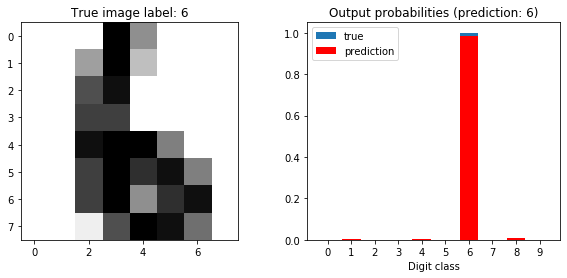

In [75]:
mlp.plot_validation_prediction(sample_id=42)

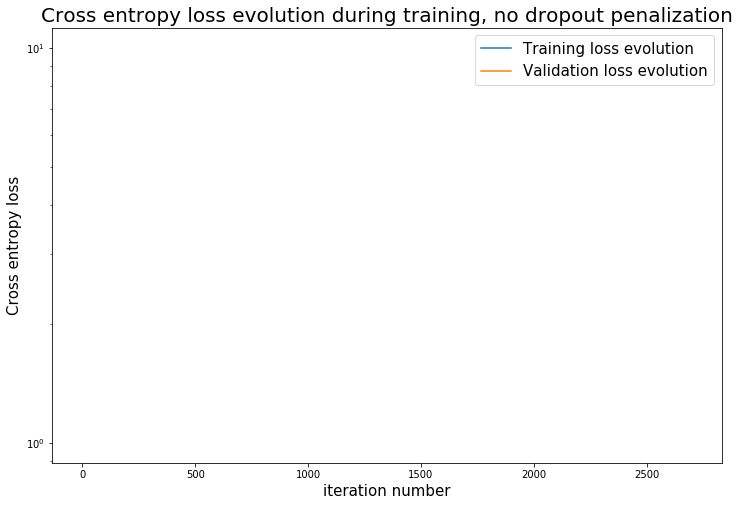

In [68]:
mlp.plot_loss_history()

# III - Multiclass classification MLP with Keras

#### - Implement the same network architecture with Keras;
    - First using the Sequential API
    - Secondly using the functional API

#### - Check that the Keras model can approximately reproduce the behavior of the Numpy model.

#### - Compute the negative log likelihood of a sample 42 in the test set (can use `model.predict_proba`).

#### - Compute the average negative log-likelihood on the full test set.

#### - Compute the average negative log-likelihood  on the full training set and check that you can get the value of the loss reported by Keras.

#### - Is the model overfitting or underfitting? (ensure that the model has fully converged by increasing the number of epochs to 500 or more if necessary).

In [78]:
X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y)
scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
X_tr = scaler.fit_transform(X_tr)
X_val = scaler.transform(X_val)

In [79]:
n_features = X[0].shape[0]
n_classes = len(np.unique(Y_tr))
n_hidden = 10

### Sequential

In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
activation = "relu"
# activation = "sigmoid"

print('Model with {} activation'.format(activation))
keras_model = Sequential()
# TODO:
keras_model.add(Dense(n_hidden,activation = activation))
keras_model.add(Dense(n_classes,activation = "softmax"))
keras_model.compile(optimizer= 'Adam', loss='sparse_categorical_crossentropy')

# This builds the model for the first time:
keras_model.fit(X_tr, Y_tr,validation_data=(X_val,Y_val), epochs=50)



Model with relu activation
Train on 1347 samples, validate on 450 samples
Epoch 1/50
1347/1347 [==============================] - 0s 267us/sample - loss: 2.2744 - val_loss: 2.1933
Epoch 2/50
1347/1347 [==============================] - 0s 48us/sample - loss: 2.1076 - val_loss: 2.0394
Epoch 3/50
1347/1347 [==============================] - 0s 49us/sample - loss: 1.9441 - val_loss: 1.8777
Epoch 4/50
1347/1347 [==============================] - 0s 48us/sample - loss: 1.7693 - val_loss: 1.7025
Epoch 5/50
1347/1347 [==============================] - 0s 50us/sample - loss: 1.5952 - val_loss: 1.5325
Epoch 6/50
1347/1347 [==============================] - 0s 52us/sample - loss: 1.4270 - val_loss: 1.3661
Epoch 7/50
1347/1347 [==============================] - 0s 62us/sample - loss: 1.2649 - val_loss: 1.2091
Epoch 8/50
1347/1347 [==============================] - 0s 60us/sample - loss: 1.1200 - val_loss: 1.0775
Epoch 9/50
1347/1347 [==============================] - 0s 57us/sample - loss: 0.9914

In [109]:
predicts = keras_model.predict_proba(X)
print(predicts[6])

[2.7477688e-35 1.2456182e-36 0.0000000e+00 0.0000000e+00 5.6247795e-35
 0.0000000e+00 1.0000000e+00 0.0000000e+00 4.2871497e-18 0.0000000e+00]


### Functional

In [110]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import layers

activation = "relu"
# activation = "sigmoid"

print('Model with {} activation'.format(activation))

inputs = Input(shape=(n_features,))
# TODO:
x = layers.Dense(n_hidden,activation = activation)(inputs)
outputs = layers.Dense(n_classes,activation = "softmax")(x)

model = Model(inputs=inputs, outputs=outputs, name='keras_model')

model.compile(optimizer= 'Adam', loss='sparse_categorical_crossentropy')

# This builds the model for the first time:
model.fit(X_tr, Y_tr,validation_data=(X_val,Y_val), epochs=5000)

Model with relu activation
Train on 1347 samples, validate on 450 samples
Epoch 1/5000
1347/1347 [==============================] - 0s 193us/sample - loss: 2.3046 - val_loss: 2.2369
Epoch 2/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 2.1714 - val_loss: 2.1147
Epoch 3/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 2.0409 - val_loss: 1.9779
Epoch 4/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 1.8909 - val_loss: 1.8247
Epoch 5/5000
1347/1347 [==============================] - 0s 48us/sample - loss: 1.7287 - val_loss: 1.6592
Epoch 6/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 1.5620 - val_loss: 1.4959
Epoch 7/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 1.3895 - val_loss: 1.3135
Epoch 8/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 1.2133 - val_loss: 1.1600
Epoch 9/5000
1347/1347 [==============================] - 0s 54us/sam

1347/1347 [==============================] - 0s 46us/sample - loss: 0.0974 - val_loss: 0.1640
Epoch 76/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 0.0958 - val_loss: 0.1642
Epoch 77/5000
1347/1347 [==============================] - 0s 48us/sample - loss: 0.0948 - val_loss: 0.1624
Epoch 78/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 0.0935 - val_loss: 0.1607
Epoch 79/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 0.0922 - val_loss: 0.1623
Epoch 80/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 0.0917 - val_loss: 0.1630
Epoch 81/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 0.0901 - val_loss: 0.1607
Epoch 82/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 0.0889 - val_loss: 0.1615
Epoch 83/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 0.0869 - val_loss: 0.1581
Epoch 84/5000
1347/1347 [=================

1347/1347 [==============================] - 0s 43us/sample - loss: 0.0380 - val_loss: 0.1481
Epoch 150/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 0.0366 - val_loss: 0.1487
Epoch 151/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 0.0365 - val_loss: 0.1485
Epoch 152/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 0.0362 - val_loss: 0.1471
Epoch 153/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 0.0358 - val_loss: 0.1498
Epoch 154/5000
1347/1347 [==============================] - 0s 47us/sample - loss: 0.0351 - val_loss: 0.1478
Epoch 155/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 0.0349 - val_loss: 0.1486
Epoch 156/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 0.0345 - val_loss: 0.1489
Epoch 157/5000
1347/1347 [==============================] - 0s 43us/sample - loss: 0.0345 - val_loss: 0.1474
Epoch 158/5000
1347/1347 [========

1347/1347 [==============================] - 0s 57us/sample - loss: 0.0155 - val_loss: 0.1591
Epoch 225/5000
1347/1347 [==============================] - 0s 48us/sample - loss: 0.0152 - val_loss: 0.1590
Epoch 226/5000
1347/1347 [==============================] - 0s 49us/sample - loss: 0.0151 - val_loss: 0.1609
Epoch 227/5000
1347/1347 [==============================] - 0s 53us/sample - loss: 0.0152 - val_loss: 0.1597
Epoch 228/5000
1347/1347 [==============================] - 0s 54us/sample - loss: 0.0146 - val_loss: 0.1595
Epoch 229/5000
1347/1347 [==============================] - 0s 56us/sample - loss: 0.0151 - val_loss: 0.1596
Epoch 230/5000
1347/1347 [==============================] - 0s 52us/sample - loss: 0.0145 - val_loss: 0.1583
Epoch 231/5000
1347/1347 [==============================] - 0s 51us/sample - loss: 0.0143 - val_loss: 0.1603
Epoch 232/5000
1347/1347 [==============================] - 0s 53us/sample - loss: 0.0145 - val_loss: 0.1626
Epoch 233/5000
1347/1347 [========

1347/1347 [==============================] - 0s 45us/sample - loss: 0.0065 - val_loss: 0.1820
Epoch 299/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 0.0064 - val_loss: 0.1770
Epoch 300/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 0.0062 - val_loss: 0.1803
Epoch 301/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 0.0063 - val_loss: 0.1767
Epoch 302/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 0.0063 - val_loss: 0.1792
Epoch 303/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 0.0060 - val_loss: 0.1808
Epoch 304/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 0.0060 - val_loss: 0.1820
Epoch 305/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 0.0058 - val_loss: 0.1800
Epoch 306/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 0.0059 - val_loss: 0.1810
Epoch 307/5000
1347/1347 [========

Epoch 373/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 0.0025 - val_loss: 0.1944
Epoch 374/5000
1347/1347 [==============================] - 0s 47us/sample - loss: 0.0026 - val_loss: 0.1955
Epoch 375/5000
1347/1347 [==============================] - ETA: 0s - loss: 3.1512e-0 - 0s 44us/sample - loss: 0.0025 - val_loss: 0.1996
Epoch 376/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 0.0025 - val_loss: 0.1965
Epoch 377/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 0.0025 - val_loss: 0.1986
Epoch 378/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 0.0024 - val_loss: 0.1982
Epoch 379/5000
1347/1347 [==============================] - 0s 49us/sample - loss: 0.0024 - val_loss: 0.1963
Epoch 380/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 0.0025 - val_loss: 0.1986
Epoch 381/5000
1347/1347 [==============================] - ETA: 0s - loss: 0.001 - 0s 45us/sample -

Epoch 447/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 9.8669e-04 - val_loss: 0.2190
Epoch 448/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 9.8265e-04 - val_loss: 0.2189
Epoch 449/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 9.8756e-04 - val_loss: 0.2202
Epoch 450/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 0.0010 - val_loss: 0.2190
Epoch 451/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 9.6282e-04 - val_loss: 0.2200
Epoch 452/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 9.1753e-04 - val_loss: 0.2201
Epoch 453/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 9.1045e-04 - val_loss: 0.2191
Epoch 454/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 8.9951e-04 - val_loss: 0.2205
Epoch 455/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 9.1627e-04 - val_

1347/1347 [==============================] - 0s 51us/sample - loss: 4.5695e-04 - val_loss: 0.2480
Epoch 520/5000
1347/1347 [==============================] - 0s 50us/sample - loss: 3.7752e-04 - val_loss: 0.2480
Epoch 521/5000
1347/1347 [==============================] - 0s 51us/sample - loss: 3.6252e-04 - val_loss: 0.2471
Epoch 522/5000
1347/1347 [==============================] - 0s 51us/sample - loss: 3.6492e-04 - val_loss: 0.2429
Epoch 523/5000
1347/1347 [==============================] - 0s 48us/sample - loss: 3.5802e-04 - val_loss: 0.2434
Epoch 524/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 3.5038e-04 - val_loss: 0.2444
Epoch 525/5000
1347/1347 [==============================] - 0s 51us/sample - loss: 3.4565e-04 - val_loss: 0.2440
Epoch 526/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 3.4279e-04 - val_loss: 0.2452
Epoch 527/5000
1347/1347 [==============================] - 0s 49us/sample - loss: 3.4260e-04 - val_loss: 0.246

1347/1347 [==============================] - 0s 45us/sample - loss: 1.4647e-04 - val_loss: 0.2623
Epoch 592/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 1.4163e-04 - val_loss: 0.2581
Epoch 593/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 1.4139e-04 - val_loss: 0.2610
Epoch 594/5000
1347/1347 [==============================] - 0s 48us/sample - loss: 1.3904e-04 - val_loss: 0.2604
Epoch 595/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 1.3744e-04 - val_loss: 0.2648
Epoch 596/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 1.3123e-04 - val_loss: 0.2642
Epoch 597/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 1.2911e-04 - val_loss: 0.2619
Epoch 598/5000
1347/1347 [==============================] - ETA: 0s - loss: 1.0980e-0 - 0s 48us/sample - loss: 1.2720e-04 - val_loss: 0.2642
Epoch 599/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 

Epoch 663/5000
1347/1347 [==============================] - 0s 49us/sample - loss: 4.9458e-05 - val_loss: 0.2859
Epoch 664/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 4.8902e-05 - val_loss: 0.2854
Epoch 665/5000
1347/1347 [==============================] - 0s 52us/sample - loss: 4.7823e-05 - val_loss: 0.2852
Epoch 666/5000
1347/1347 [==============================] - 0s 48us/sample - loss: 4.7423e-05 - val_loss: 0.2882
Epoch 667/5000
1347/1347 [==============================] - ETA: 0s - loss: 2.2717e-0 - 0s 47us/sample - loss: 4.6843e-05 - val_loss: 0.2882
Epoch 668/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 4.6720e-05 - val_loss: 0.2879
Epoch 669/5000
1347/1347 [==============================] - 0s 49us/sample - loss: 4.7461e-05 - val_loss: 0.2846
Epoch 670/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 4.5809e-05 - val_loss: 0.2847
Epoch 671/5000
1347/1347 [==============================] - ETA: 0s 

1347/1347 [==============================] - 0s 46us/sample - loss: 2.3213e-05 - val_loss: 0.3227
Epoch 735/5000
1347/1347 [==============================] - ETA: 0s - loss: 2.4749e-0 - 0s 45us/sample - loss: 1.7472e-05 - val_loss: 0.3147
Epoch 736/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 1.6944e-05 - val_loss: 0.3127
Epoch 737/5000
1347/1347 [==============================] - 0s 50us/sample - loss: 1.6602e-05 - val_loss: 0.3114
Epoch 738/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 1.5562e-05 - val_loss: 0.3121
Epoch 739/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 1.5745e-05 - val_loss: 0.3141
Epoch 740/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 1.5628e-05 - val_loss: 0.3141
Epoch 741/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 1.5349e-05 - val_loss: 0.3113
Epoch 742/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 

Epoch 806/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 5.7683e-06 - val_loss: 0.3352
Epoch 807/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 5.7097e-06 - val_loss: 0.3355
Epoch 808/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 5.7149e-06 - val_loss: 0.3375
Epoch 809/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 5.7295e-06 - val_loss: 0.3376
Epoch 810/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 5.7346e-06 - val_loss: 0.3375
Epoch 811/5000
1347/1347 [==============================] - ETA: 0s - loss: 2.3469e-0 - 0s 45us/sample - loss: 5.6503e-06 - val_loss: 0.3364
Epoch 812/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 5.2840e-06 - val_loss: 0.3384
Epoch 813/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 5.3525e-06 - val_loss: 0.3379
Epoch 814/5000
1347/1347 [==============================] - 0s 43us/

1347/1347 [==============================] - 0s 45us/sample - loss: 1.9566e-06 - val_loss: 0.3578
Epoch 878/5000
1347/1347 [==============================] - 0s 48us/sample - loss: 2.0725e-06 - val_loss: 0.3589
Epoch 879/5000
1347/1347 [==============================] - 0s 47us/sample - loss: 1.8759e-06 - val_loss: 0.3583
Epoch 880/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 1.8608e-06 - val_loss: 0.3576
Epoch 881/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 1.8158e-06 - val_loss: 0.3604
Epoch 882/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 1.7999e-06 - val_loss: 0.3610
Epoch 883/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 1.7609e-06 - val_loss: 0.3606
Epoch 884/5000
1347/1347 [==============================] - 0s 48us/sample - loss: 1.7611e-06 - val_loss: 0.3604
Epoch 885/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 1.7521e-06 - val_loss: 0.360

Epoch 949/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 6.6100e-07 - val_loss: 0.3846
Epoch 950/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 7.1180e-07 - val_loss: 0.3827
Epoch 951/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 6.4764e-07 - val_loss: 0.3854
Epoch 952/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 6.3852e-07 - val_loss: 0.3844
Epoch 953/5000
1347/1347 [==============================] - 0s 47us/sample - loss: 6.3985e-07 - val_loss: 0.3868
Epoch 954/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 6.0684e-07 - val_loss: 0.3850
Epoch 955/5000
1347/1347 [==============================] - 0s 47us/sample - loss: 6.2295e-07 - val_loss: 0.3853
Epoch 956/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 6.1596e-07 - val_loss: 0.3857
Epoch 957/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 6.0312e-07 - 

Epoch 1021/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 2.3992e-07 - val_loss: 0.4081
Epoch 1022/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 2.3028e-07 - val_loss: 0.4089
Epoch 1023/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 2.3585e-07 - val_loss: 0.4081
Epoch 1024/5000
1347/1347 [==============================] - 0s 48us/sample - loss: 2.2904e-07 - val_loss: 0.4081
Epoch 1025/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 2.2267e-07 - val_loss: 0.4077
Epoch 1026/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 2.3736e-07 - val_loss: 0.4103
Epoch 1027/5000
1347/1347 [==============================] - 0s 48us/sample - loss: 2.7107e-07 - val_loss: 0.4120
Epoch 1028/5000
1347/1347 [==============================] - 0s 48us/sample - loss: 2.2028e-07 - val_loss: 0.4108
Epoch 1029/5000
1347/1347 [==============================] - 0s 49us/sample - loss: 2.16

Epoch 1092/5000
1347/1347 [==============================] - 0s 52us/sample - loss: 9.4695e-08 - val_loss: 0.4287
Epoch 1093/5000
1347/1347 [==============================] - 0s 47us/sample - loss: 9.5403e-08 - val_loss: 0.4266
Epoch 1094/5000
1347/1347 [==============================] - 0s 50us/sample - loss: 9.3987e-08 - val_loss: 0.4289
Epoch 1095/5000
1347/1347 [==============================] - 0s 49us/sample - loss: 9.2571e-08 - val_loss: 0.4273
Epoch 1096/5000
1347/1347 [==============================] - 0s 52us/sample - loss: 9.0712e-08 - val_loss: 0.4278
Epoch 1097/5000
1347/1347 [==============================] - 0s 48us/sample - loss: 9.0004e-08 - val_loss: 0.4275
Epoch 1098/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 8.8057e-08 - val_loss: 0.4290
Epoch 1099/5000
1347/1347 [==============================] - ETA: 0s - loss: 1.0431e-0 - 0s 52us/sample - loss: 9.1066e-08 - val_loss: 0.4301
Epoch 1100/5000
1347/1347 [==============================] -

1347/1347 [==============================] - 0s 64us/sample - loss: 4.4427e-08 - val_loss: 0.4466
Epoch 1164/5000
1347/1347 [==============================] - 0s 61us/sample - loss: 4.6462e-08 - val_loss: 0.4462
Epoch 1165/5000
1347/1347 [==============================] - 0s 56us/sample - loss: 4.3984e-08 - val_loss: 0.4460
Epoch 1166/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 4.4338e-08 - val_loss: 0.4475
Epoch 1167/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 4.3630e-08 - val_loss: 0.4468
Epoch 1168/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 4.3365e-08 - val_loss: 0.4474
Epoch 1169/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 4.1772e-08 - val_loss: 0.4461
Epoch 1170/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 4.2214e-08 - val_loss: 0.4475
Epoch 1171/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 4.1152e-08 - val_los

1347/1347 [==============================] - 0s 46us/sample - loss: 2.6904e-08 - val_loss: 0.4590
Epoch 1235/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 2.5399e-08 - val_loss: 0.4584
Epoch 1236/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 2.4426e-08 - val_loss: 0.4598
Epoch 1237/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 2.5311e-08 - val_loss: 0.4596
Epoch 1238/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 2.5134e-08 - val_loss: 0.4601
Epoch 1239/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 2.4249e-08 - val_loss: 0.4599
Epoch 1240/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 2.4160e-08 - val_loss: 0.4601
Epoch 1241/5000
1347/1347 [==============================] - 0s 48us/sample - loss: 2.4957e-08 - val_loss: 0.4601
Epoch 1242/5000
1347/1347 [==============================] - 0s 48us/sample - loss: 2.3718e-08 - val_los

1347/1347 [==============================] - 0s 52us/sample - loss: 1.6638e-08 - val_loss: 0.4707
Epoch 1307/5000
1347/1347 [==============================] - 0s 51us/sample - loss: 1.6726e-08 - val_loss: 0.4700
Epoch 1308/5000
1347/1347 [==============================] - 0s 51us/sample - loss: 1.8231e-08 - val_loss: 0.4691
Epoch 1309/5000
1347/1347 [==============================] - 0s 54us/sample - loss: 1.6903e-08 - val_loss: 0.4706
Epoch 1310/5000
1347/1347 [==============================] - 0s 52us/sample - loss: 1.6638e-08 - val_loss: 0.4727
Epoch 1311/5000
1347/1347 [==============================] - 0s 51us/sample - loss: 1.6018e-08 - val_loss: 0.4716
Epoch 1312/5000
1347/1347 [==============================] - 0s 54us/sample - loss: 1.5841e-08 - val_loss: 0.4712
Epoch 1313/5000
1347/1347 [==============================] - 0s 52us/sample - loss: 1.6018e-08 - val_loss: 0.4715
Epoch 1314/5000
1347/1347 [==============================] - 0s 52us/sample - loss: 1.5930e-08 - val_los

1347/1347 [==============================] - 0s 46us/sample - loss: 1.3009e-08 - val_loss: 0.4773
Epoch 1378/5000
1347/1347 [==============================] - ETA: 0s - loss: 1.4901e-0 - 0s 45us/sample - loss: 1.2301e-08 - val_loss: 0.4768
Epoch 1379/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 1.2036e-08 - val_loss: 0.4770
Epoch 1380/5000
1347/1347 [==============================] - 0s 50us/sample - loss: 1.2390e-08 - val_loss: 0.4756
Epoch 1381/5000
1347/1347 [==============================] - 0s 58us/sample - loss: 1.2124e-08 - val_loss: 0.4766
Epoch 1382/5000
1347/1347 [==============================] - 0s 53us/sample - loss: 1.2567e-08 - val_loss: 0.4762
Epoch 1383/5000
1347/1347 [==============================] - 0s 54us/sample - loss: 1.1859e-08 - val_loss: 0.4774
Epoch 1384/5000
1347/1347 [==============================] - 0s 58us/sample - loss: 1.2036e-08 - val_loss: 0.4761
Epoch 1385/5000
1347/1347 [==============================] - 0s 60us/sample 

1347/1347 [==============================] - 0s 45us/sample - loss: 9.7350e-09 - val_loss: 0.4795
Epoch 1448/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 9.3810e-09 - val_loss: 0.4800
Epoch 1449/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 9.6465e-09 - val_loss: 0.4805
Epoch 1450/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 9.3810e-09 - val_loss: 0.4802
Epoch 1451/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 9.5580e-09 - val_loss: 0.4807
Epoch 1452/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 9.4695e-09 - val_loss: 0.4801
Epoch 1453/5000
1347/1347 [==============================] - 0s 50us/sample - loss: 9.3810e-09 - val_loss: 0.4800
Epoch 1454/5000
1347/1347 [==============================] - 0s 52us/sample - loss: 9.2040e-09 - val_loss: 0.4801
Epoch 1455/5000
1347/1347 [==============================] - 0s 50us/sample - loss: 1.0000e-08 - val_los

1347/1347 [==============================] - 0s 47us/sample - loss: 7.1685e-09 - val_loss: 0.4831
Epoch 1519/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 7.7880e-09 - val_loss: 0.4832
Epoch 1520/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 7.9650e-09 - val_loss: 0.4810
Epoch 1521/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 7.2570e-09 - val_loss: 0.4827
Epoch 1522/5000
1347/1347 [==============================] - 0s 43us/sample - loss: 7.7880e-09 - val_loss: 0.4850
Epoch 1523/5000
1347/1347 [==============================] - 0s 49us/sample - loss: 7.0800e-09 - val_loss: 0.4839
Epoch 1524/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 6.7260e-09 - val_loss: 0.4833
Epoch 1525/5000
1347/1347 [==============================] - 0s 47us/sample - loss: 6.8145e-09 - val_loss: 0.4838
Epoch 1526/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 7.0800e-09 - val_los

Epoch 1589/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 6.4605e-09 - val_loss: 0.4832
Epoch 1590/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 6.7260e-09 - val_loss: 0.4839
Epoch 1591/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 7.0800e-09 - val_loss: 0.4843
Epoch 1592/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 6.9915e-09 - val_loss: 0.4844
Epoch 1593/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 7.0800e-09 - val_loss: 0.4844
Epoch 1594/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 6.9915e-09 - val_loss: 0.4843
Epoch 1595/5000
1347/1347 [==============================] - 0s 54us/sample - loss: 6.5490e-09 - val_loss: 0.4846
Epoch 1596/5000
1347/1347 [==============================] - 0s 54us/sample - loss: 6.5490e-09 - val_loss: 0.4846
Epoch 1597/5000
1347/1347 [==============================] - 0s 52us/sample - loss: 6.90

Epoch 1661/5000
1347/1347 [==============================] - 0s 69us/sample - loss: 6.1065e-09 - val_loss: 0.4864
Epoch 1662/5000
1347/1347 [==============================] - 0s 62us/sample - loss: 6.4605e-09 - val_loss: 0.4865
Epoch 1663/5000
1347/1347 [==============================] - 0s 53us/sample - loss: 6.5490e-09 - val_loss: 0.4870
Epoch 1664/5000
1347/1347 [==============================] - 0s 54us/sample - loss: 6.5490e-09 - val_loss: 0.4862
Epoch 1665/5000
1347/1347 [==============================] - 0s 54us/sample - loss: 6.1065e-09 - val_loss: 0.4865
Epoch 1666/5000
1347/1347 [==============================] - 0s 47us/sample - loss: 6.2835e-09 - val_loss: 0.4868
Epoch 1667/5000
1347/1347 [==============================] - 0s 48us/sample - loss: 6.1950e-09 - val_loss: 0.4864
Epoch 1668/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 5.9295e-09 - val_loss: 0.4868
Epoch 1669/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 6.54

Epoch 1733/5000
1347/1347 [==============================] - 0s 48us/sample - loss: 5.4870e-09 - val_loss: 0.4891
Epoch 1734/5000
1347/1347 [==============================] - 0s 48us/sample - loss: 5.8410e-09 - val_loss: 0.4885
Epoch 1735/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 5.7525e-09 - val_loss: 0.4882
Epoch 1736/5000
1347/1347 [==============================] - 0s 48us/sample - loss: 5.6640e-09 - val_loss: 0.4879
Epoch 1737/5000
1347/1347 [==============================] - 0s 48us/sample - loss: 5.8410e-09 - val_loss: 0.4887
Epoch 1738/5000
1347/1347 [==============================] - 0s 54us/sample - loss: 5.8410e-09 - val_loss: 0.4884
Epoch 1739/5000
1347/1347 [==============================] - 0s 52us/sample - loss: 5.5755e-09 - val_loss: 0.4887
Epoch 1740/5000
1347/1347 [==============================] - 0s 50us/sample - loss: 5.6640e-09 - val_loss: 0.4882
Epoch 1741/5000
1347/1347 [==============================] - 0s 49us/sample - loss: 5.57

1347/1347 [==============================] - 0s 49us/sample - loss: 5.1330e-09 - val_loss: 0.4915
Epoch 1805/5000
1347/1347 [==============================] - 0s 48us/sample - loss: 5.4870e-09 - val_loss: 0.4918
Epoch 1806/5000
1347/1347 [==============================] - 0s 47us/sample - loss: 5.5755e-09 - val_loss: 0.4916
Epoch 1807/5000
1347/1347 [==============================] - 0s 48us/sample - loss: 5.8410e-09 - val_loss: 0.4915
Epoch 1808/5000
1347/1347 [==============================] - 0s 47us/sample - loss: 6.0180e-09 - val_loss: 0.4921
Epoch 1809/5000
1347/1347 [==============================] - 0s 49us/sample - loss: 4.5135e-09 - val_loss: 0.4920
Epoch 1810/5000
1347/1347 [==============================] - 0s 48us/sample - loss: 5.4870e-09 - val_loss: 0.4918
Epoch 1811/5000
1347/1347 [==============================] - 0s 51us/sample - loss: 5.6640e-09 - val_loss: 0.4922
Epoch 1812/5000
1347/1347 [==============================] - 0s 51us/sample - loss: 5.1330e-09 - val_los

1347/1347 [==============================] - 0s 46us/sample - loss: 5.5755e-09 - val_loss: 0.4936
Epoch 1876/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 4.7790e-09 - val_loss: 0.4943
Epoch 1877/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 5.2215e-09 - val_loss: 0.4940
Epoch 1878/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 5.6640e-09 - val_loss: 0.4942
Epoch 1879/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 5.7525e-09 - val_loss: 0.4937
Epoch 1880/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 5.2215e-09 - val_loss: 0.4945
Epoch 1881/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 5.4870e-09 - val_loss: 0.4936
Epoch 1882/5000
1347/1347 [==============================] - 0s 43us/sample - loss: 5.3100e-09 - val_loss: 0.4938
Epoch 1883/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 5.3100e-09 - val_los

1347/1347 [==============================] - 0s 49us/sample - loss: 5.5755e-09 - val_loss: 0.4988
Epoch 1947/5000
1347/1347 [==============================] - 0s 43us/sample - loss: 4.6020e-09 - val_loss: 0.4990
Epoch 1948/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 4.6905e-09 - val_loss: 0.4981
Epoch 1949/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 5.5755e-09 - val_loss: 0.4983
Epoch 1950/5000
1347/1347 [==============================] - 0s 47us/sample - loss: 4.6020e-09 - val_loss: 0.4991
Epoch 1951/5000
1347/1347 [==============================] - 0s 49us/sample - loss: 5.3100e-09 - val_loss: 0.4993
Epoch 1952/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 5.2215e-09 - val_loss: 0.4994
Epoch 1953/5000
1347/1347 [==============================] - ETA: 0s - loss: 3.7253e-0 - 0s 45us/sample - loss: 4.9560e-09 - val_loss: 0.4990
Epoch 1954/5000
1347/1347 [==============================] - 0s 48us/sample 

1347/1347 [==============================] - 0s 55us/sample - loss: 4.9560e-09 - val_loss: 0.50350
Epoch 2017/5000
1347/1347 [==============================] - 0s 55us/sample - loss: 4.9560e-09 - val_loss: 0.5042
Epoch 2018/5000
1347/1347 [==============================] - 0s 50us/sample - loss: 4.5135e-09 - val_loss: 0.5043
Epoch 2019/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 5.2215e-09 - val_loss: 0.5044
Epoch 2020/5000
1347/1347 [==============================] - 0s 56us/sample - loss: 4.5135e-09 - val_loss: 0.5043
Epoch 2021/5000
1347/1347 [==============================] - 0s 57us/sample - loss: 4.9560e-09 - val_loss: 0.5042
Epoch 2022/5000
1347/1347 [==============================] - 0s 52us/sample - loss: 5.3100e-09 - val_loss: 0.5043
Epoch 2023/5000
1347/1347 [==============================] - 0s 57us/sample - loss: 5.0445e-09 - val_loss: 0.5041
Epoch 2024/5000
1347/1347 [==============================] - 0s 49us/sample - loss: 4.4250e-09 - val_lo

Epoch 2088/5000
1347/1347 [==============================] - 0s 56us/sample - loss: 4.9560e-09 - val_loss: 0.50520
Epoch 2089/5000
1347/1347 [==============================] - 0s 55us/sample - loss: 4.3365e-09 - val_loss: 0.5049
Epoch 2090/5000
1347/1347 [==============================] - 0s 53us/sample - loss: 4.8675e-09 - val_loss: 0.5057
Epoch 2091/5000
1347/1347 [==============================] - 0s 60us/sample - loss: 4.8675e-09 - val_loss: 0.5053
Epoch 2092/5000
1347/1347 [==============================] - 0s 57us/sample - loss: 4.7790e-09 - val_loss: 0.5048
Epoch 2093/5000
1347/1347 [==============================] - 0s 55us/sample - loss: 4.8675e-09 - val_loss: 0.5045
Epoch 2094/5000
1347/1347 [==============================] - 0s 54us/sample - loss: 4.9560e-09 - val_loss: 0.5053
Epoch 2095/5000
1347/1347 [==============================] - 0s 50us/sample - loss: 4.8675e-09 - val_loss: 0.5056
Epoch 2096/5000
1347/1347 [==============================] - 0s 51us/sample - loss: 4.9

1347/1347 [==============================] - 0s 46us/sample - loss: 4.6905e-09 - val_loss: 0.5039
Epoch 2160/5000
1347/1347 [==============================] - 0s 46us/sample - loss: 4.9560e-09 - val_loss: 0.5036
Epoch 2161/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 4.9560e-09 - val_loss: 0.5043
Epoch 2162/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 4.6905e-09 - val_loss: 0.5040
Epoch 2163/5000
1347/1347 [==============================] - 0s 43us/sample - loss: 4.2480e-09 - val_loss: 0.5051
Epoch 2164/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 4.6020e-09 - val_loss: 0.5046
Epoch 2165/5000
1347/1347 [==============================] - 0s 47us/sample - loss: 4.6020e-09 - val_loss: 0.5044
Epoch 2166/5000
1347/1347 [==============================] - 0s 45us/sample - loss: 4.5135e-09 - val_loss: 0.5048
Epoch 2167/5000
1347/1347 [==============================] - 0s 44us/sample - loss: 4.7790e-09 - val_los

KeyboardInterrupt: 

#### Now that you know if the model is underfitting or overfitting:
#### - In case of underfitting, can you explain why ? Also change the structure of the 2 previous networks to cancell underfitting
#### - In case of overfitting, explain why and change the structure of the 2 previous networks to cancell the overfitting

- Our model does not overfit